In [1]:
# importing the required packages and libraries for the data manipulaton
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the dataset

In [3]:
telecom_data = pd.read_csv("telecom_churn_data.csv")
telecom_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
#checking the dimensions of the dataset
telecom_data.shape

(99999, 226)

### Filtering the High Value Customers

#### As per the data definition the customers who recharge more than the 70th percentile or more than the average recharge amount in the first two months ( the good phase)
Deriving the features to extract the highvalue customers.


To derive the high value customers we need to fnd out the total amount spent by the customers on data recharge.


There are two columns through which we can find the values. 


First column is av_rech_amt_data_x (x represents month here, would be either 6, 7, 8 or 9)


Second column is total_rech_data_x (x represnts month here, would be either 6, 7, 8 or 9)

av_rech_amt_data_x * total_rech_data_x can be used to calculate the new column to be introduced total_rech_data_amt_x

In [5]:
telecom_data['total_rech_data_amt_6'] = telecom_data['av_rech_amt_data_6'] * telecom_data['total_rech_data_6']
telecom_data['total_rech_data_amt_7'] = telecom_data['av_rech_amt_data_7'] * telecom_data['total_rech_data_7']
telecom_data['total_rech_data_amt_8'] = telecom_data['av_rech_amt_data_8'] * telecom_data['total_rech_data_8']
telecom_data['total_rech_data_amt_9'] = telecom_data['av_rech_amt_data_9'] * telecom_data['total_rech_data_9']

Since we have the new column as required now we dont need the old columns for the data nalysis hence just removing the columnstat are not required from the dataset

In [6]:
telecom_data.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)

Finding out the average recharge done by the users in the frst two months

In [7]:
telecom_data_temp = (telecom_data['total_rech_amt_6'].fillna(0) 
+ telecom_data['total_rech_amt_7'].fillna(0) 
+ telecom_data['total_rech_data_amt_6'].fillna(0) 
+ telecom_data['total_rech_data_amt_7'].fillna(0))/2

Taking the 70 percentle of the calculated average amount

In [8]:
telecom_data70=np.percentile(telecom_data_temp, 70.0)
print("70 percentile is : ", telecom_data70)

70 percentile is :  478.0


Filtering the given dataset on the basis of 70th percentile data

In [9]:
telecom_data_hv = telecom_data[telecom_data_temp >= telecom_data70]

In [10]:
telecom_data_hv.shape

(30001, 222)

Introducing new column for churn values, the new column would be either 1 for churn or 0 for no churn

In [11]:
telecom_data_hv['churn'] = np.where(telecom_data_hv[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
telecom_data_hv.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0


Finding out the churn/no-churn percentage from the dataset

In [12]:
telecom_data_hv['churn'].value_counts()/len(telecom_data_hv)*100

0    91.863605
1     8.136395
Name: churn, dtype: float64

From the above data we see that only 8% of the customers churn. This churning result might be due to a class imbalance. We would be dealing with the class imbalance at a later stage

## Cleaning the Dataset

Checking the columns in the dataset with no variance in their values. We would drop such columns from the dataset as they would provide no important addition to the data analysis.

In [13]:
for i in telecom_data_hv.columns:
    if telecom_data_hv[i].nunique() == 1:
        
        print("\nColumn",i,"has no variance and contains only", telecom_data_hv[i].nunique(),"unique value")
        print("Dropping the column",i)
        telecom_data_hv.drop(i,axis=1,inplace = True)
        


Column circle_id has no variance and contains only 1 unique value
Dropping the column circle_id

Column loc_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_og_t2o_mou

Column std_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column std_og_t2o_mou

Column loc_ic_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_ic_t2o_mou

Column last_date_of_month_6 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_6

Column last_date_of_month_7 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_7

Column last_date_of_month_8 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_8

Column last_date_of_month_9 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_9

Column std_og_t2c_mou_6 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_m

In [14]:
telecom_data_hv.shape

(30001, 207)

#### Checking for all the null values present in the dataset

In [15]:
(telecom_data_hv.isnull().sum() * 100 / len(telecom_data_hv)).sort_values(ascending = False)

total_rech_data_amt_9    49.268358
count_rech_3g_9          49.268358
arpu_3g_9                49.268358
arpu_2g_9                49.268358
night_pck_user_9         49.268358
                           ...    
last_day_rch_amt_7        0.000000
last_day_rch_amt_8        0.000000
last_day_rch_amt_9        0.000000
vol_2g_mb_6               0.000000
mobile_number             0.000000
Length: 207, dtype: float64

Dropping the columns with more than 30% of the values missing from the columns. We would not be removing the data for the 9th Month Column as we would be requiring the data for the analysis at a later part

In [16]:
cols = telecom_data_hv.columns
telecom_null_perc = telecom_data_hv.isnull().sum() * 100 / len(telecom_data_hv)
telecom_null_df = pd.DataFrame({'col_name': cols,
                                 'perc_null': telecom_null_perc})

drop_cols = telecom_null_df.loc[(telecom_null_df["col_name"].str.contains('_9')==False) & (telecom_null_df["perc_null"] > 30.0)]["col_name"]
print("list of columns dropped:",drop_cols)

# lets drop these columns
telecom_data_hv.drop(drop_cols, axis=1,inplace = True)
telecom_data_hv.shape

list of columns dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6     

(30001, 180)

Checking the columns for the values where the datatypes could be changed to more simple or utilized datatypes for better analizing of the data

In [17]:
column_data_object =telecom_data_hv.select_dtypes(include=['object'])

In [18]:
print(column_data_object.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


The above observed columns from the result can be converted to data type of date or date type

In [19]:
# converting the datatype to date for easy understanding of the dataset
for col in column_data_object.columns:
    telecom_data_hv[col] = pd.to_datetime(telecom_data_hv[col])

telecom_data_hv.shape


(30001, 180)

Checking the correlation among the features and then droping  the highly correlated features from the dataset

In [20]:
cor=telecom_data_hv.corr()
cor.loc[:,:] = np.tril(cor, k=-1)

In [21]:
cor=cor.stack()
cor[(cor>0.60)|(cor<-0.60)].sort_values()

monthly_3g_6      vol_3g_mb_6         0.601308
total_ic_mou_7    loc_ic_t2t_mou_7    0.601684
arpu_2g_9         count_rech_3g_9     0.602386
total_og_mou_8    onnet_mou_9         0.603450
total_rech_amt_8  arpu_6              0.603673
                                        ...   
isd_og_mou_8      isd_og_mou_7        0.949809
                  isd_og_mou_6        0.950194
total_rech_amt_9  arpu_9              0.950539
total_rech_amt_8  arpu_8              0.955351
sachet_2g_9       count_rech_2g_9     0.980131
Length: 337, dtype: float64

Setting the threshold for correlation at 60% for the dataset and deleting/dropping the columns with correlaton more than the set threshold

In [22]:
col_list_drop =['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']

In [23]:
telecom_data_hv.drop(col_list_drop, axis=1, inplace=True)

In [24]:
telecom_data_hv.shape

(30001, 125)

For predicting the churn/ non-churn data we would utilize the data from the first three months. We do not require the 9th month data hence dropping the column from the dataset

In [25]:
column_drop=[col for col in telecom_data_hv.columns if '_9' in col]
print(column_drop)

telecom_data_hv.drop(column_drop, axis=1, inplace=True)
telecom_data_hv.shape

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'total_rech_data_amt_9']


(30001, 88)

Rechecking the dataset for checking the null values in columns in dataset

In [26]:
(telecom_data_hv.isnull().sum()*100/len(telecom_data_hv)).sort_values(ascending=False)

std_og_mou_8        3.913203
std_ic_t2f_mou_8    3.913203
ic_others_8         3.913203
loc_og_mou_8        3.913203
isd_ic_mou_8        3.913203
                      ...   
max_rech_amt_7      0.000000
max_rech_amt_6      0.000000
total_rech_num_8    0.000000
total_rech_num_7    0.000000
mobile_number       0.000000
Length: 88, dtype: float64

There are a few columns with about 4% of the data missing from the columns in the dataset

Dropping the rows with the null values from the dataset becuase these values would not add anything.

In [27]:
# dropping the rows with the null variables
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['onnet_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['onnet_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['onnet_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['offnet_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['offnet_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['offnet_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['roam_ic_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['roam_ic_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['roam_ic_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['roam_og_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['roam_og_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['roam_og_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_og_t2c_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_og_t2c_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_og_t2c_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_og_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_og_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_og_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_og_t2f_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_og_t2f_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_og_t2f_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_og_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_og_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_og_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['isd_og_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['isd_og_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['isd_og_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['spl_og_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['spl_og_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['spl_og_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['og_others_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['og_others_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['og_others_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_ic_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_ic_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['loc_ic_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_t2t_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_t2t_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_t2t_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_t2f_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_t2f_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_t2f_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['std_ic_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['spl_ic_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['spl_ic_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['spl_ic_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['isd_ic_mou_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['isd_ic_mou_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['isd_ic_mou_8'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['ic_others_6'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['ic_others_7'])]
telecom_data_hv = telecom_data_hv[~np.isnan(telecom_data_hv['ic_others_8'])]

Checking the dataset again to see the values of the dataset

In [28]:
(telecom_data_hv.isnull().sum() * 100 / len(telecom_data_hv)).sort_values(ascending = False)

churn               0.0
sep_vbc_3g          0.0
std_og_t2f_mou_7    0.0
std_og_t2f_mou_8    0.0
std_og_mou_6        0.0
                   ... 
total_rech_num_8    0.0
max_rech_amt_6      0.0
max_rech_amt_7      0.0
max_rech_amt_8      0.0
mobile_number       0.0
Length: 88, dtype: float64

In [29]:
# writing a function for plotting a histogram for some random sample column
def ColumnDistribution(df, Shown, PerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + PerRow - 1) / PerRow
    plt.figure(num = None, figsize = (6 * PerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, Shown)):
        plt.subplot(nGraphRow, PerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show() 

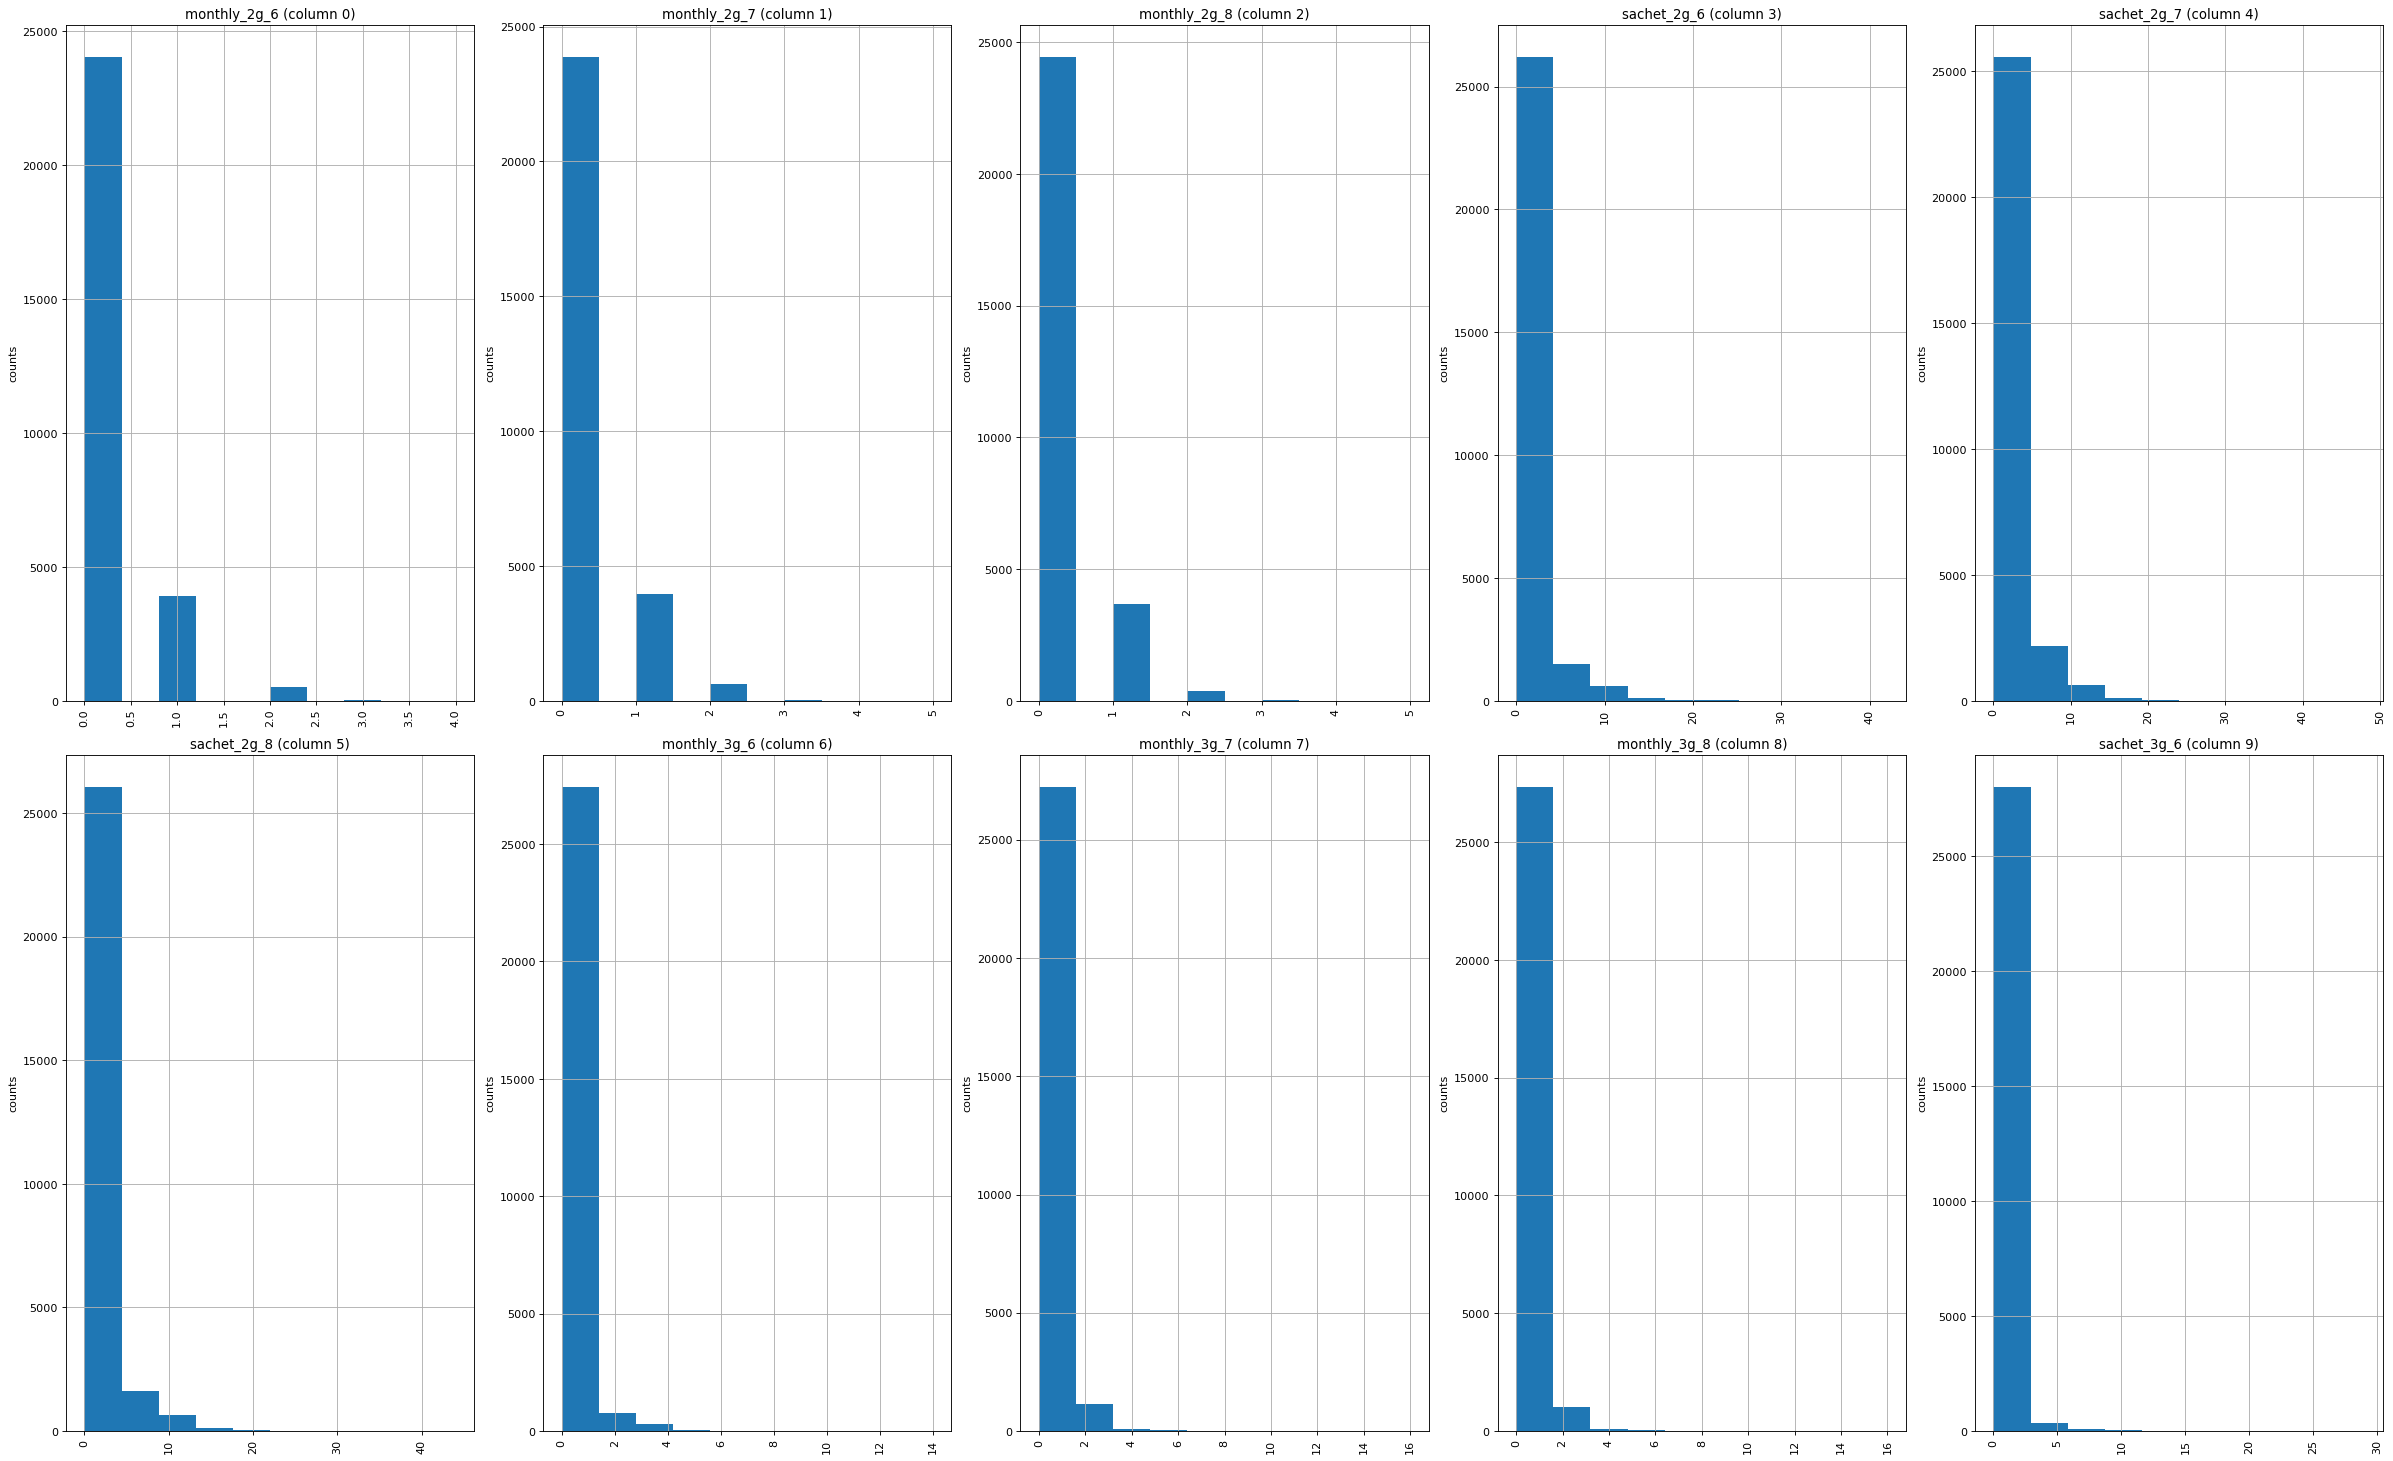

In [30]:
# call the function to plot the graphs
ColumnDistribution(telecom_data_hv, 10, 5)

In [31]:
# constructing a function to plot correlation matrix
def CorrelationMatrix(df, Width):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(Width, Width), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


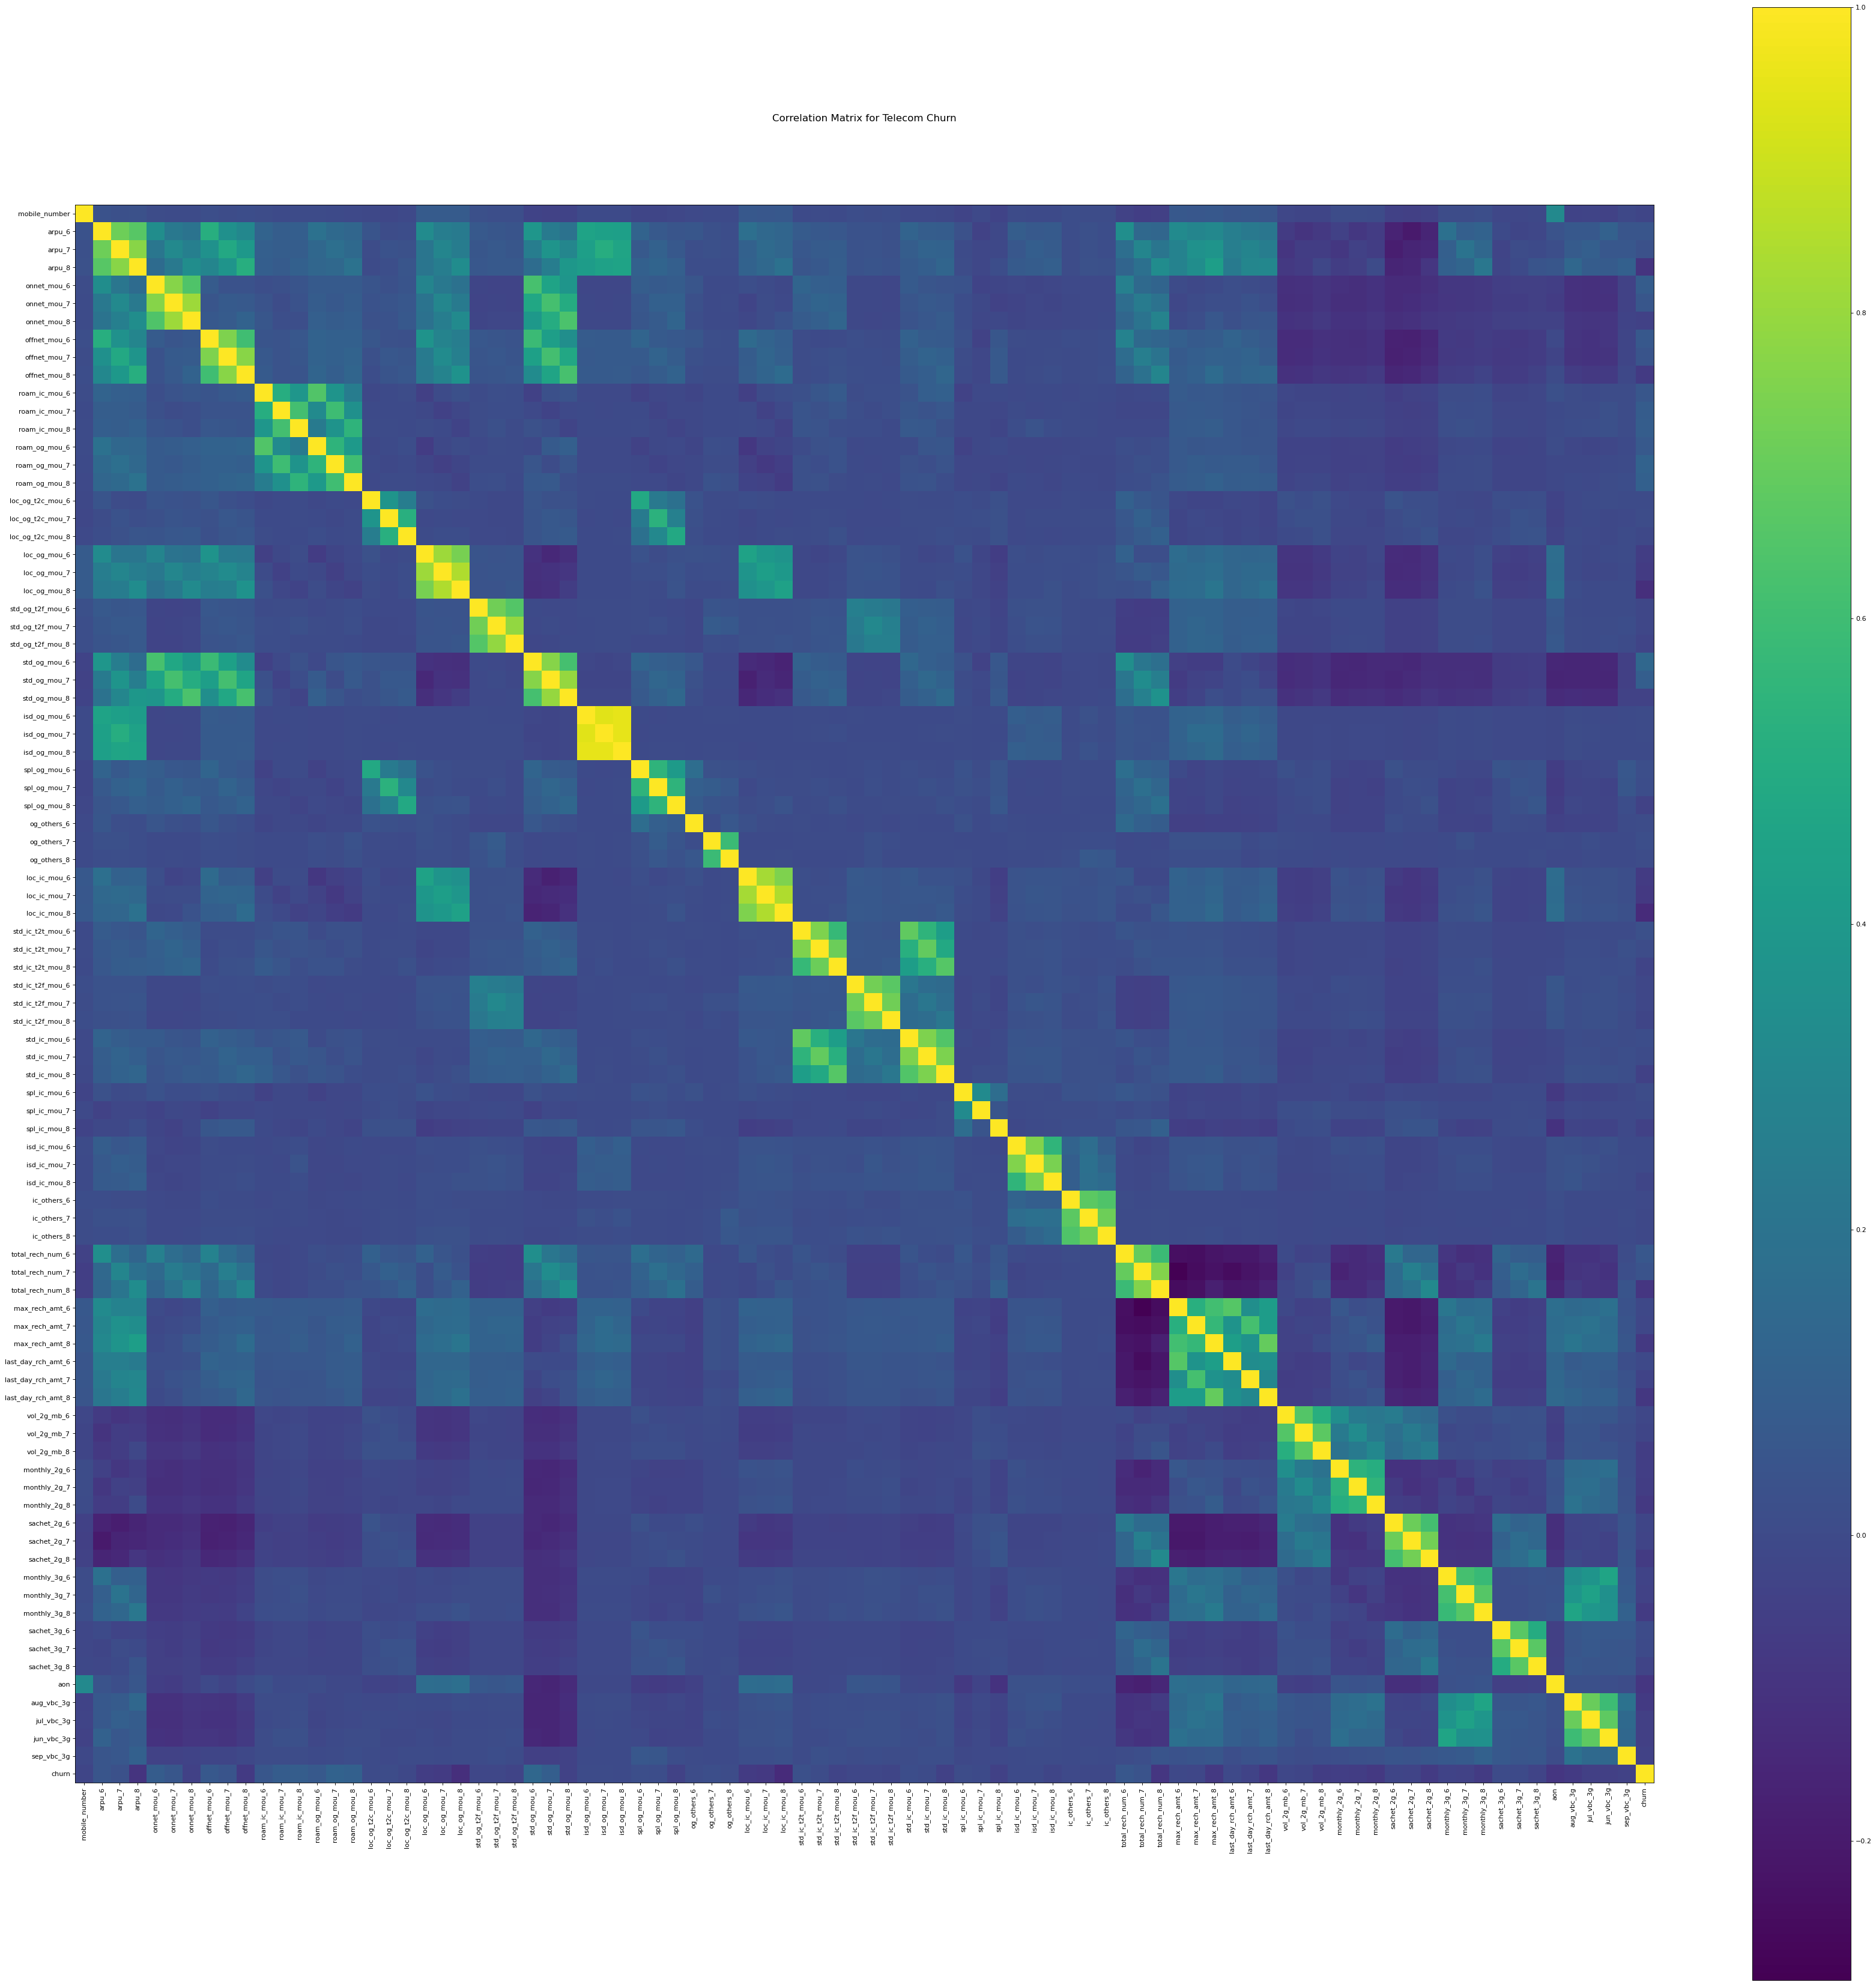

In [32]:
CorrelationMatrix(telecom_data_hv, 53)

In [33]:
# constructing a function to plot scatter plots

In [34]:
def ScatterMatrix(df, pSize, tSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    colNames = list(df)
    if len(colNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        colNames = colNames[:10]
    df = df[colNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[pSize, pSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=tSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

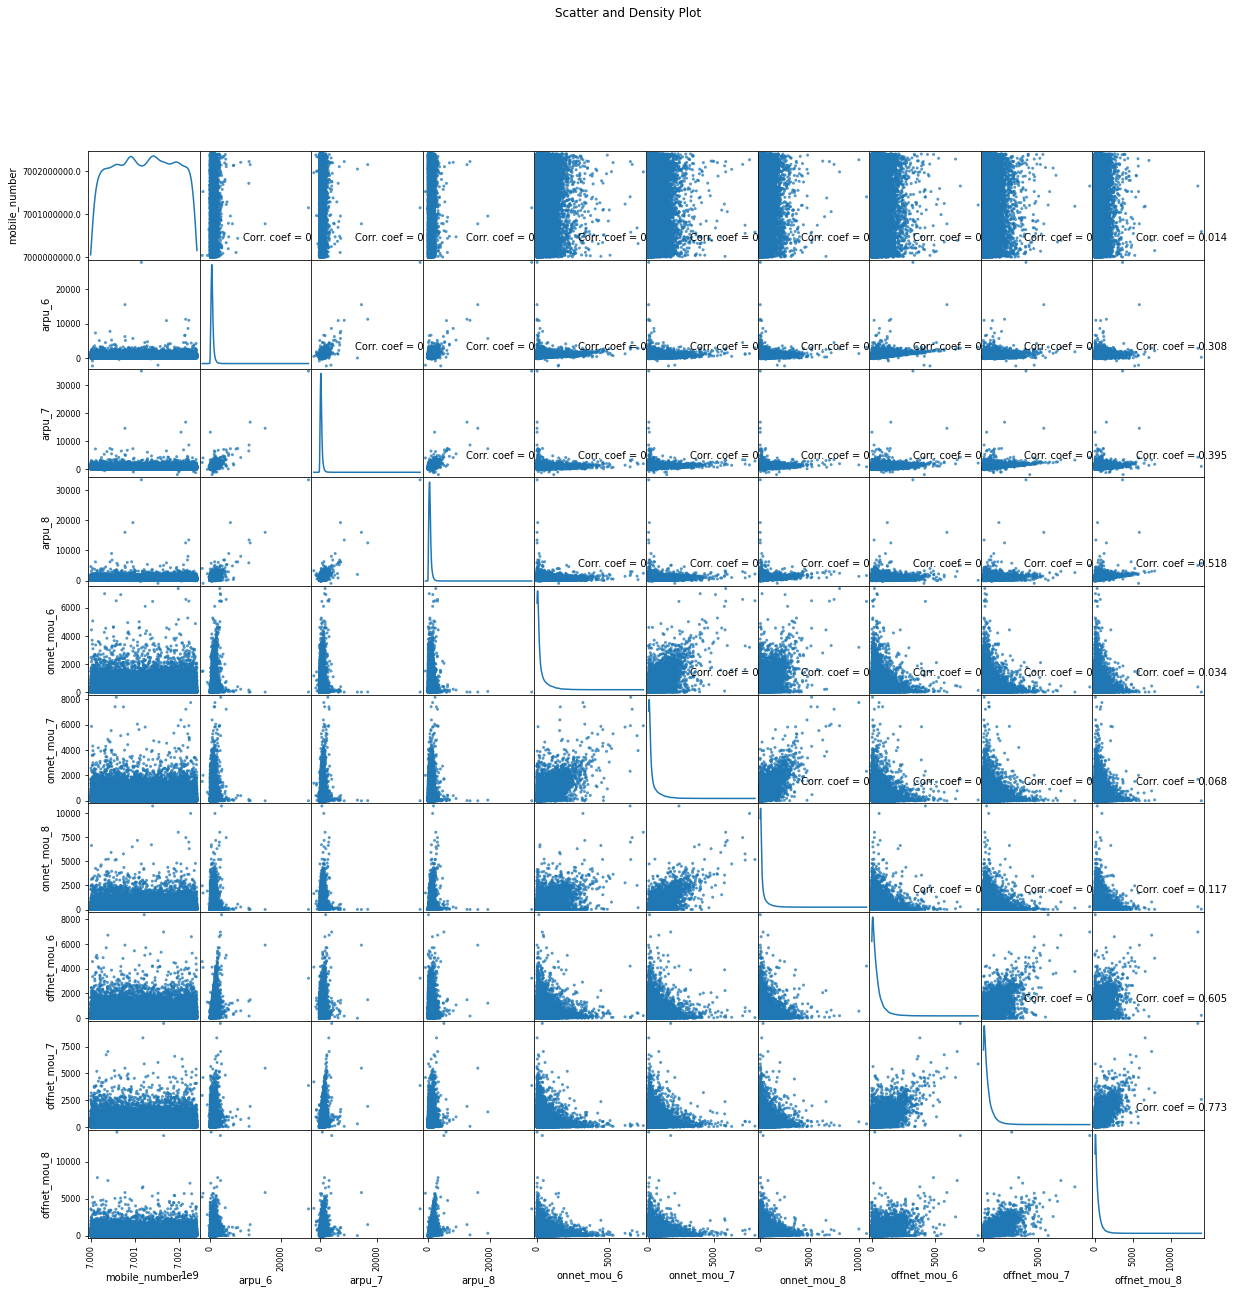

In [35]:
ScatterMatrix(telecom_data_hv, 20, 10)

#### Derived Metrix

Deriving some new features from the existing columns to get more insight

Finding the average of the 6th and 7th months. Starting with getting a list of columns with 6th and 7th months

In [36]:
column_list= telecom_data_hv.filter(regex='_6|_7').columns.str[:-2]
column_list.unique()

Index(['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou',
       'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2f_mou', 'std_og_mou',
       'isd_og_mou', 'spl_og_mou', 'og_others', 'loc_ic_mou', 'std_ic_t2t_mou',
       'std_ic_t2f_mou', 'std_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others',
       'total_rech_num', 'max_rech_amt', 'last_day_rch_amt', 'vol_2g_mb',
       'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g'],
      dtype='object')

In [37]:
telecom_data_hv.shape

(28504, 88)

Taking the average for the columns with 6th and 7th month

In [38]:
for idx, col in enumerate(column_list.unique()):
    col_name_average='avg_'+col+"_av67"  #creating the column name dynamically
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_data_hv[col_name_average]= (telecom_data_hv[col_6]+telecom_data_hv[col_7])/2
    

Removing the columns from the database from which the columns have been derived

In [39]:
telecom_data_hv.shape

(28504, 115)

In [40]:
drop_column = telecom_data_hv.filter(regex='_6|_7').columns

In [41]:
telecom_data_hv.drop(drop_column, axis=1, inplace=True)

In [42]:
telecom_data_hv.shape

(28504, 61)

Converting the AON in months

In [43]:
telecom_data_hv['aon_mon'] = telecom_data_hv['aon']/30
telecom_data_hv.drop('aon', axis=1, inplace=True)
telecom_data_hv['aon_mon'].head()

7     26.733333
8     10.500000
21    24.000000
23    20.133333
33    44.266667
Name: aon_mon, dtype: float64

Drawing all the plots with the updated dataset


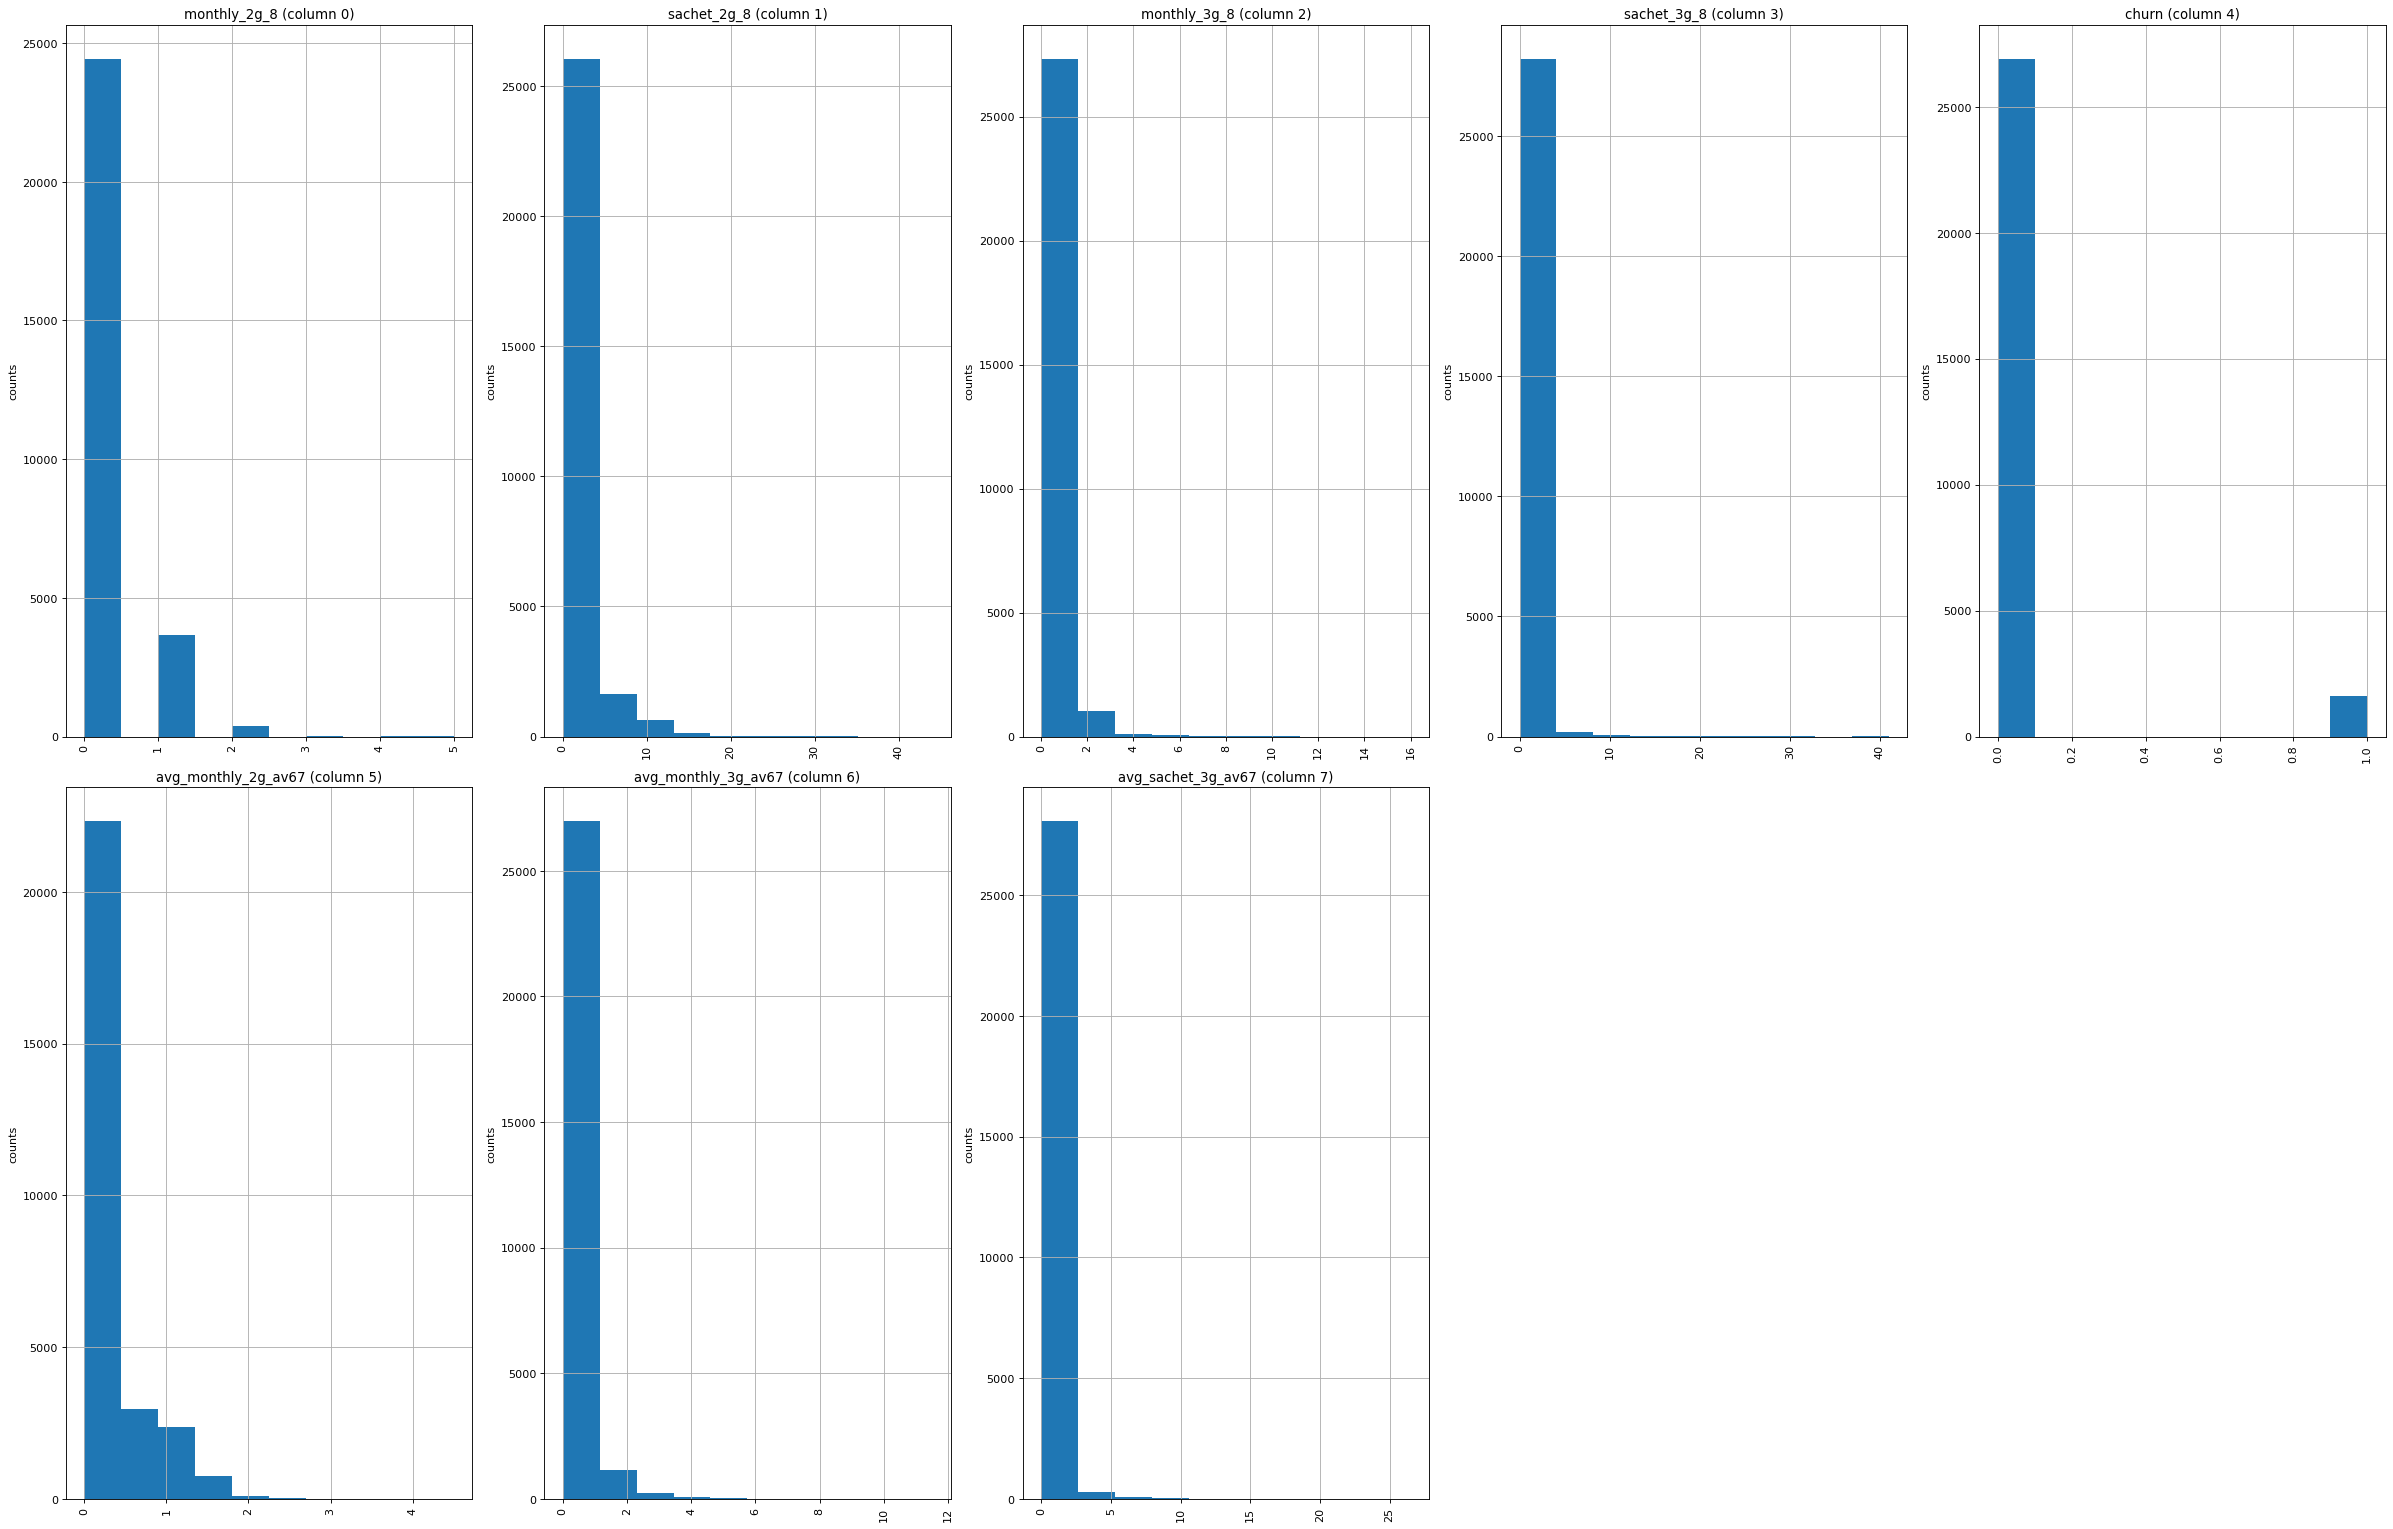

In [44]:
ColumnDistribution(telecom_data_hv, 10, 5)

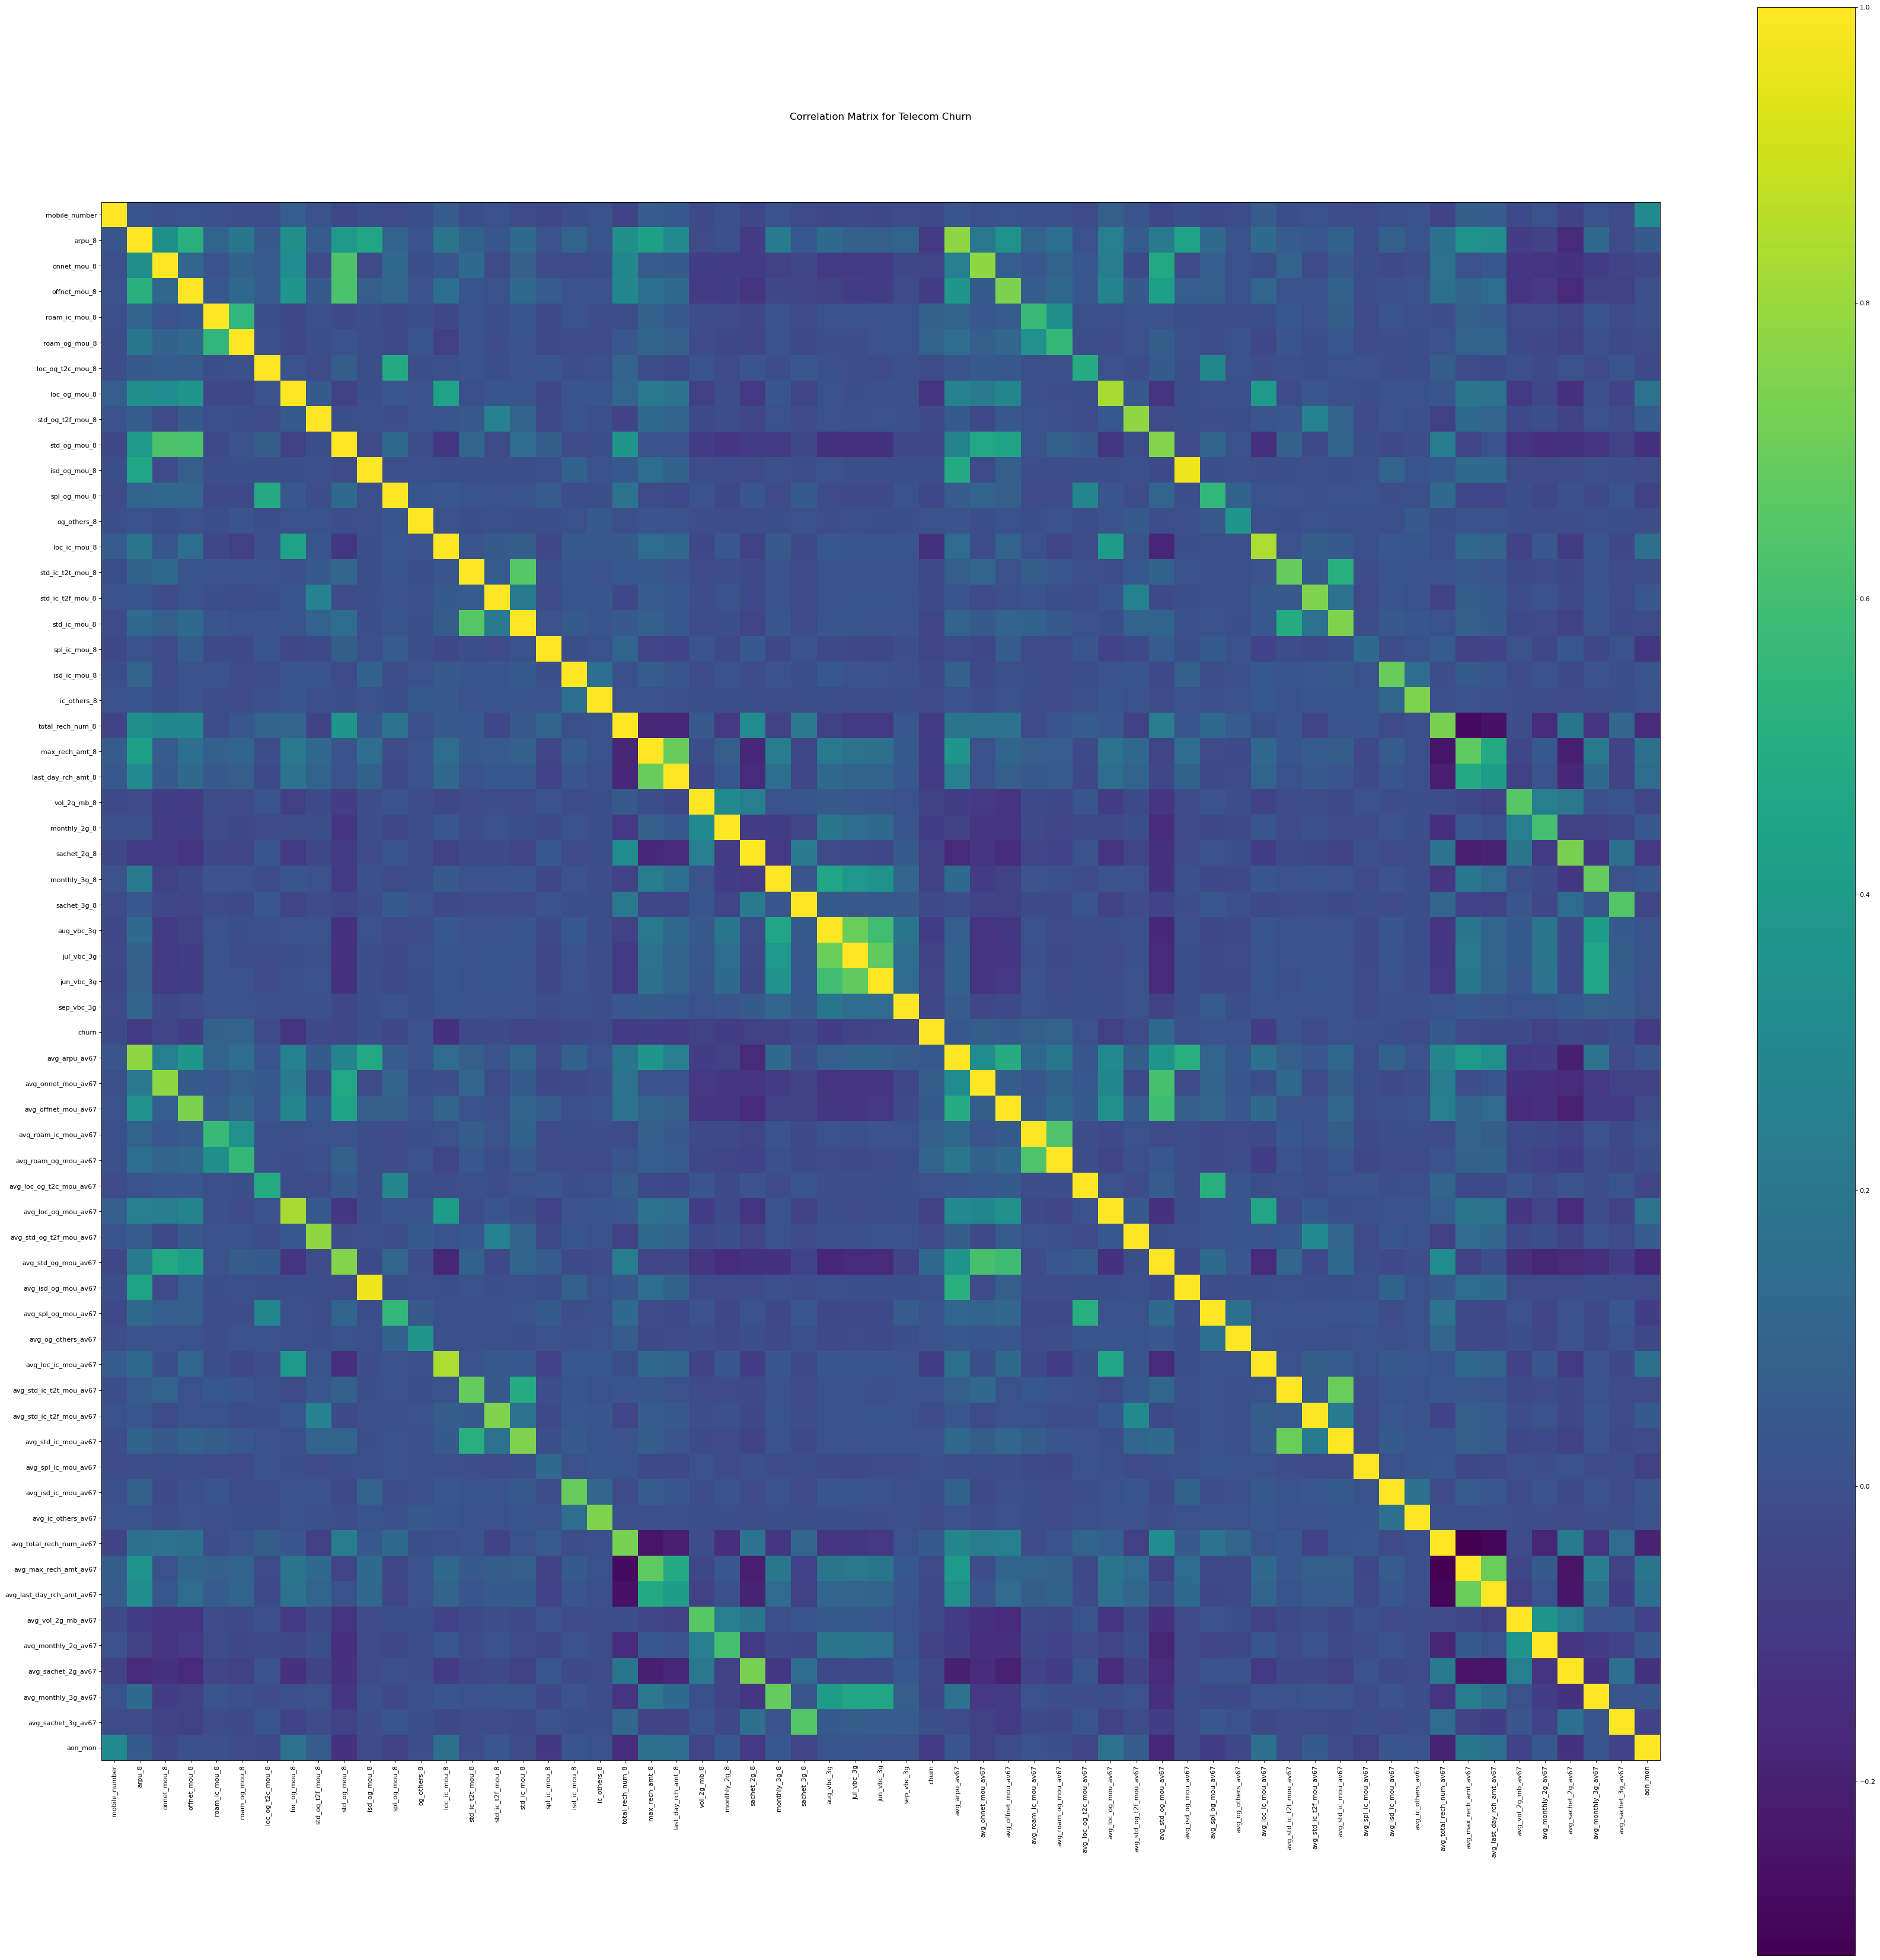

In [45]:
CorrelationMatrix(telecom_data_hv, 53)

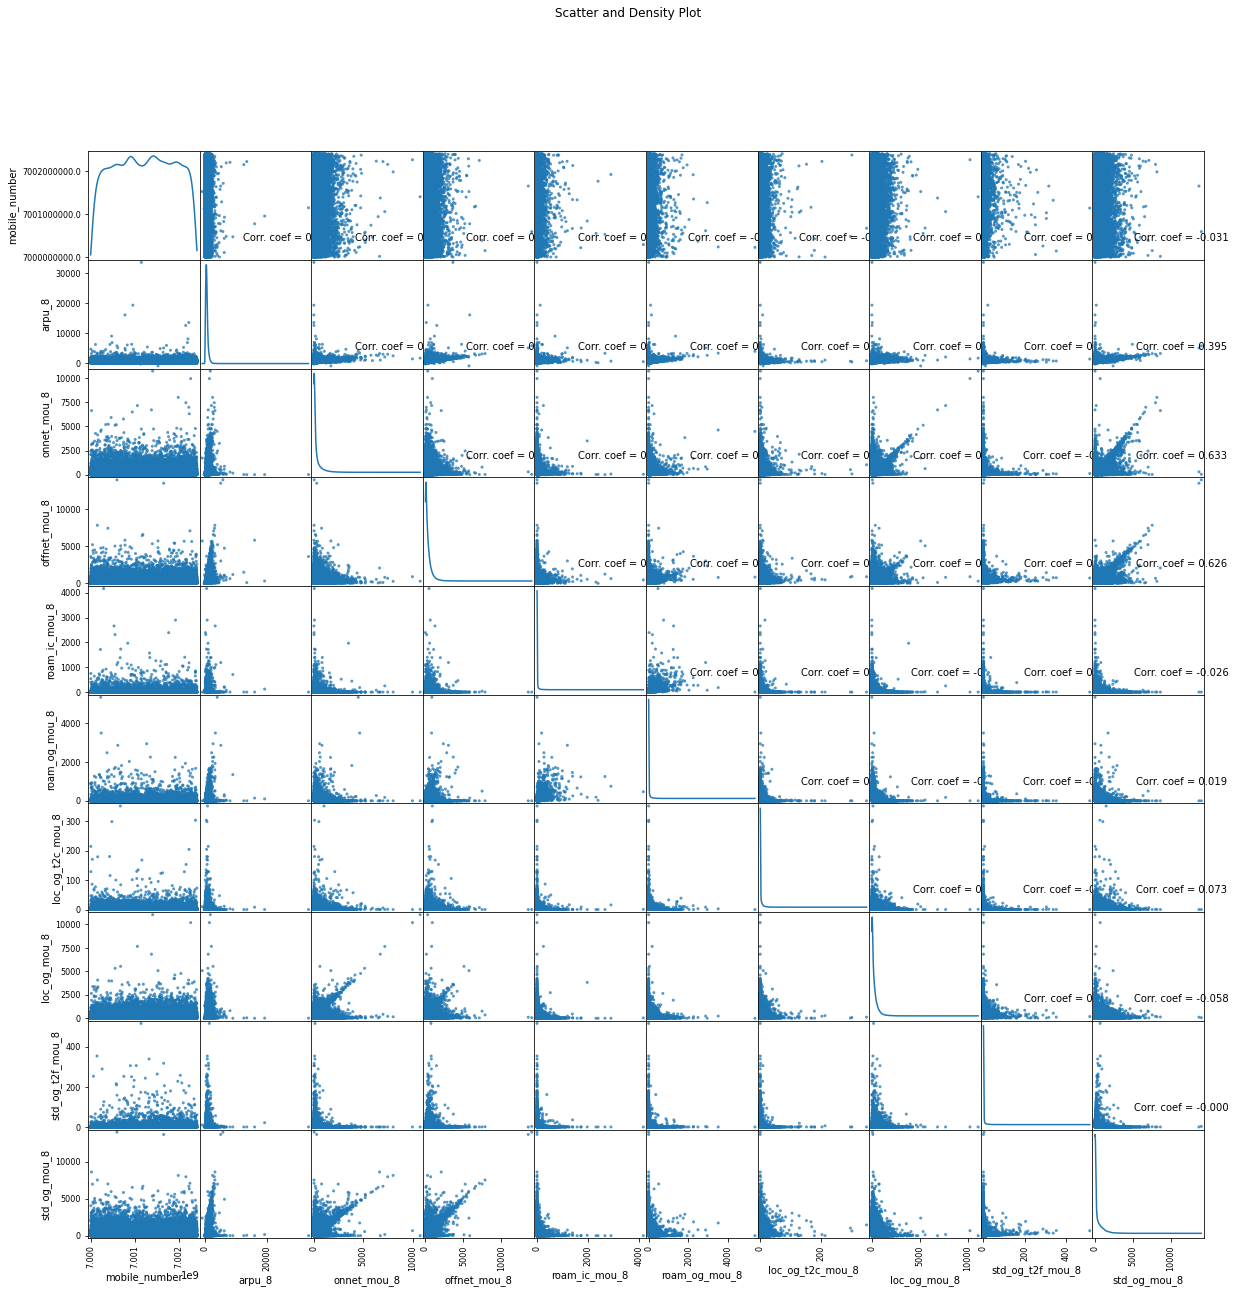

In [46]:
ScatterMatrix(telecom_data_hv, 20, 10)

Plotting a graph to show the tenure of the customers

Text(0.5, 1.0, 'Tenure Graph')

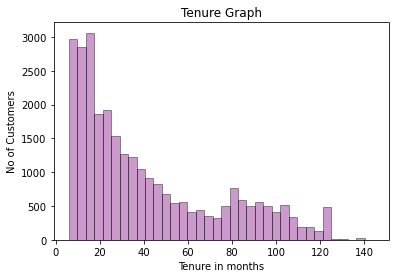

In [47]:
histplot = sns.distplot(telecom_data_hv['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 25})
histplot.set_ylabel('No of Customers')
histplot.set_xlabel('Tenure in months')
histplot.set_title('Tenure Graph')

In [48]:
range_tenure = [0, 6, 12, 24, 60, 61]
label_tenure = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_data_hv['tenure_range'] = pd.cut(telecom_data_hv['aon_mon'], range_tenure, labels=label_tenure)
telecom_data_hv['tenure_range'].head()

7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
33        2-5 Yrs
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

Taking the churn column and checking the correlation of the churn column with the other columns

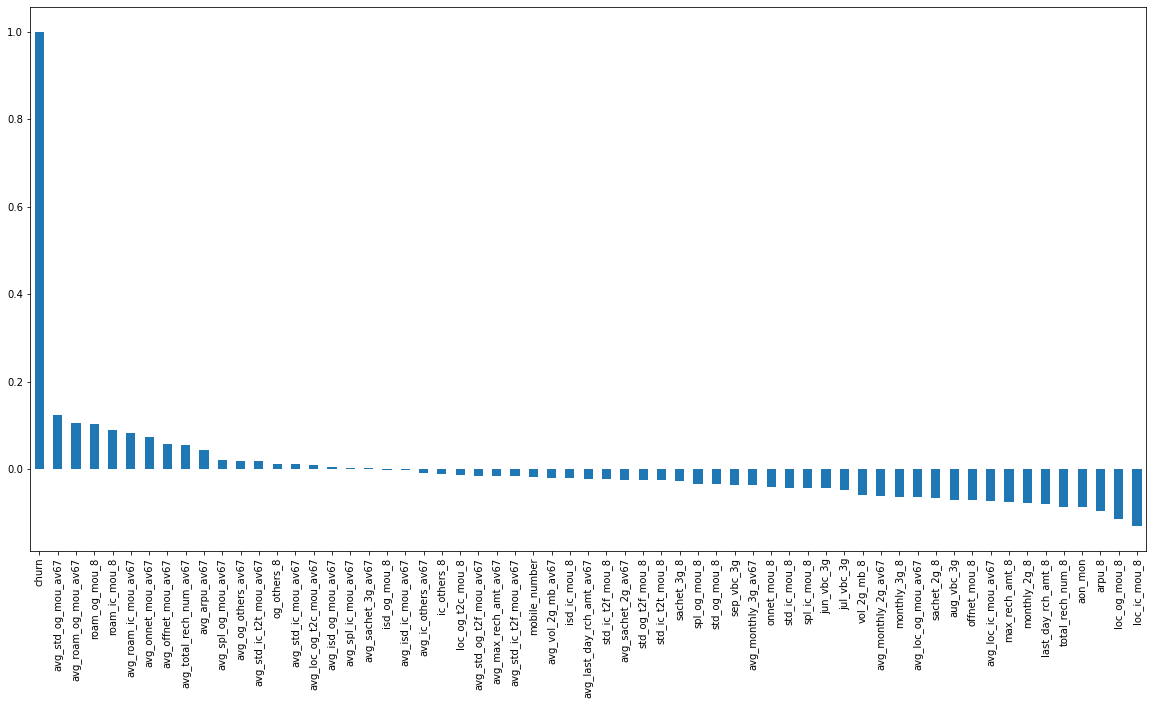

In [49]:
plt.figure(figsize=(20,10))
telecom_data_hv.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

Some of the observations from the Above plotted graph:-
1. There is a positive correlation between the churn and average outgoing calls and calls on roaming for the 6th and 7th month.
2. Negative correlation can be seen between churn and avegrage revenue, number of recharges.

Plotting a scatter plot between average revenue and total recharge for the 8th monrh

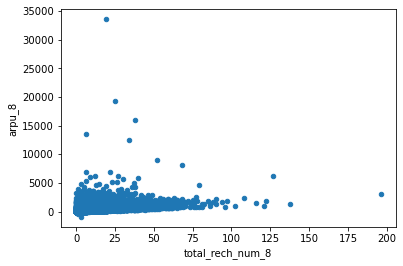

In [50]:
telecom_data_hv[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8', y='arpu_8')

Plotting a graph between tenure and revenue

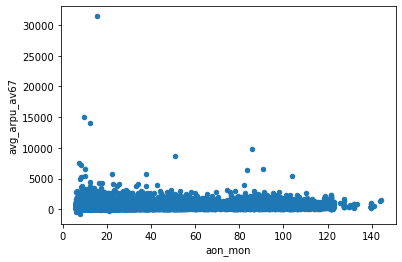

In [51]:
telecom_data_hv[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon',y='avg_arpu_av67')

### Visualising Churn Vs. Other features

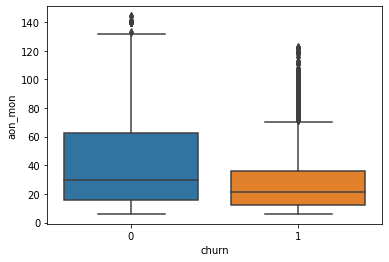

In [52]:
sns.boxplot(x = telecom_data_hv.churn, y = telecom_data_hv.aon_mon)

As per the abpve box plots, we can see that the tenured customers tend to not churn and rather keep avaiing the services

#### Churn Vs Base Cost

Text(0.5, 1.0, 'Churn Vs Base Cost')

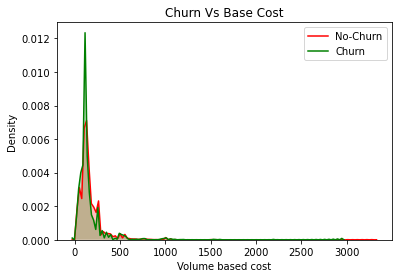

In [53]:
histplot = sns.kdeplot(telecom_data_hv.avg_max_rech_amt_av67[(telecom_data_hv["churn"] == 0)],
                color="Red", shade = True)
histplot = sns.kdeplot(telecom_data_hv.avg_max_rech_amt_av67[(telecom_data_hv["churn"] == 1)],
                ax=histplot, color="Green", shade= True)
histplot.legend(["No-Churn","Churn"],loc='upper right')
histplot.set_ylabel('Density')
histplot.set_xlabel('Volume based cost')
histplot.set_title('Churn Vs Base Cost')

#### Maximum Recharge amount vs The Churn Rate

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

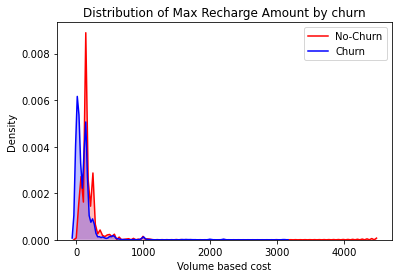

In [54]:
histplot = sns.kdeplot(telecom_data_hv.max_rech_amt_8[(telecom_data_hv["churn"] == 0)],
                color="Red", shade = True)
histplot = sns.kdeplot(telecom_data_hv.max_rech_amt_8[(telecom_data_hv["churn"] == 1)],
                ax =histplot, color="Blue", shade= True)
histplot.legend(["No-Churn","Churn"],loc='upper right')
histplot.set_ylabel('Density')
histplot.set_xlabel('Volume based cost')
histplot.set_title('Distribution of Max Recharge Amount by churn')

### Model Building

Creating a new dataset for model building

In [55]:
churndf = telecom_data_hv[:].copy()

Dropping the columns from dataset with high correlation with AON Month column

In [56]:
churndf.drop('tenure_range', axis=1, inplace=True)
churndf.drop('mobile_number', axis=1, inplace=True)
churndf.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,aon_mon
7,3171.480,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,...,15.465,5.0,1185.0,0.0,0.000,0.0,0.0,0.0,0.0,26.733333
8,137.362,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,...,0.000,20.0,122.0,25.0,178.000,0.5,0.5,0.0,0.0,10.500000
21,637.760,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,...,0.000,24.0,50.0,25.0,0.000,0.0,0.0,0.0,0.0,24.000000
23,366.966,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,...,2.675,4.0,89.5,89.5,0.240,0.0,0.0,1.0,0.0,20.133333
33,409.230,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,...,0.940,10.5,753.5,126.0,72.405,0.0,0.0,4.5,2.0,44.266667


Splitting the X and Y dataset for building the model. Churn will be assigned to Y while X will not have churn 

In [57]:
X = churndf.drop(['churn'], axis=1)
y = churndf['churn']

churndf.drop('churn', axis=1, inplace=True)

Scaling the dataset and standardising the values of the dataset

In [58]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

Splitting the dataset on the test and train dataset

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (19952, 59)
Dimension of X_test: (8552, 59)


Balancing the skewed dataset and the given dataset is skewed

In [60]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()

X_tr,y_tr = sm.fit_resample(X_train,y_train)

In [61]:
print("Dimension of X_tr Shape:", X_tr.shape)
print("Dimension of y_tr Shape:", y_tr.shape)

print("Imbalance in Training dataset:",(y_tr != 0).sum()/(y_tr == 0).sum())

Dimension of X_tr Shape: (37666, 59)
Dimension of y_tr Shape: (37666,)
Imbalance in Training dataset: 1.0


Building the Linear SVM Model

In [62]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

lr = LogisticRegression()

lr.svm = SVC(kernel='linear') 
lr.svm.fit(X_train,y_train)
preds = lr.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.9419400105244694

As per the above results we can see that the Linear SVM gave us the accuracy of about 94.2%

Now using RFE for feature reduction to make the model more robust for analysis

In [63]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.feature_selection import RFE

# lets RFE select 15 most imp features for us
rfe = RFE(lr, 15)   
rfe = rfe.fit(X_tr, y_tr)

In [64]:
rfe_features = list(churndf.columns[rfe.support_])
print("15 most important features selected by RFE ", rfe_features)

15 most important features selected by RFE  ['onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sep_vbc_3g', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'aon_mon']


In [65]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

For the Columns selected by RFE creating the Logistic Regression Model

In [66]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

LogisticRegression(random_state=1)

In [68]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print('Accuracy on the test dataset:',lr.score(X_test_rfe, y_test))

[[4216 1154]
 [  63  268]]
Accuracy on the test dataset: 0.7865286791790914


Checking the classification report on the above designed dataset

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.79      0.87      5370
           1       0.19      0.81      0.31       331

    accuracy                           0.79      5701
   macro avg       0.59      0.80      0.59      5701
weighted avg       0.94      0.79      0.84      5701



#### Conclusion from the above model:
1. From the above results for the model the Model Accuracy is about 79%
2. The False Positive Rate for the model is very high which is not a good sign

We need to try another model for better Results. 

Hence, now trying PCA or Principal Component Analysis for the dataset to get the better results

### Principal Component Analysis(P.C.A.)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# to correct the class imbalance we would be applying SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)


(37666, 59)
(37666,)


In [73]:
#Importing PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

# apply PCA on train data
pca.fit(X_tr)

PCA(random_state=100)

In [74]:
X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(37666, 59)
(8552, 59)


In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_tr_pca, y_tr)

# making the predictions
y_pred = lr_pca.predict(X_test_pca)

# convert prediction array into a dataframe
y_pred_df = pd.DataFrame(y_pred)

In [76]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))
print("Accuracy of the logistic regression model with PCA: ",accuracy_score(y_test,y_pred))

[[6496 1579]
 [  93  384]]
Accuracy of the logistic regression model with PCA:  0.804490177736202


In [77]:
col = list(churndf.columns)
df_pca = pd.DataFrame({'PC-1':pca.components_[0],'PC-2':pca.components_[1], 'PC-3':pca.components_[2],'Feature':col})
df_pca.head(10)

,PC-1,PC-2,PC-3,Feature
0,0.202712,0.197849,0.186728,arpu_8
1,0.088929,0.207761,-0.045104,onnet_mou_8
2,0.137919,0.202141,0.050872,offnet_mou_8
3,0.362274,-0.197638,-0.093470,roam_ic_mou_8
4,0.382276,-0.138365,-0.111748,roam_og_mou_8
5,0.018476,0.088288,-0.024093,loc_og_t2c_mou_8
6,0.046449,0.119414,0.181669,loc_og_mou_8
7,0.025594,0.021470,0.081399,std_og_t2f_mou_8
8,0.077538,0.260244,-0.090342,std_og_mou_8
9,0.056012,0.069588,0.103373,isd_og_mou_8


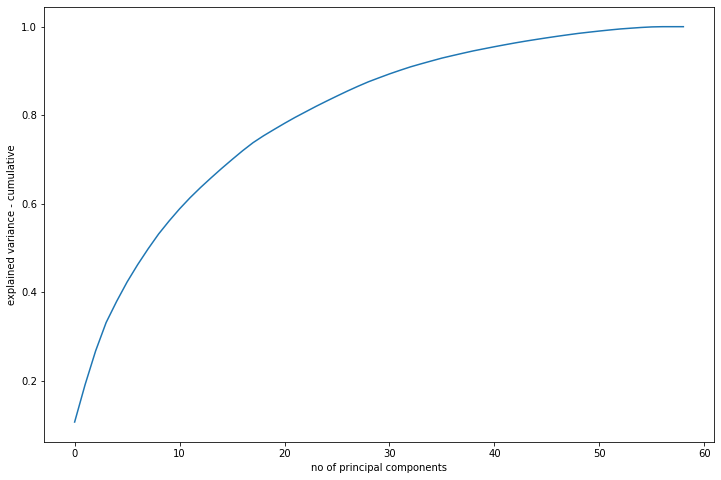

In [78]:
# To explain the variance explained by different PCAs we will draw scree plot
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('no of principal components')
plt.ylabel('explained variance - cumulative')
plt.show()

In [79]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.61,  19.09,  26.7 ,  33.11,  37.89,  42.28,  46.18,  49.77,
        53.13,  56.07,  58.82,  61.34,  63.65,  65.83,  67.94,  69.97,
        71.95,  73.79,  75.35,  76.77,  78.16,  79.5 ,  80.75,  82.  ,
        83.19,  84.34,  85.47,  86.54,  87.56,  88.46,  89.34,  90.15,
        90.93,  91.61,  92.27,  92.92,  93.48,  94.03,  94.56,  95.03,
        95.5 ,  95.94,  96.37,  96.77,  97.15,  97.51,  97.86,  98.19,
        98.51,  98.78,  99.04,  99.28,  99.51,  99.68,  99.85,  99.97,
       100.02, 100.02, 100.02])

33 columns explains 90% of the variance, lets apply PCA with 33 components

In [80]:
# PCA with 33 components
pca_33 = PCA(n_components=33)

df_tr_pca_33 = pca_33.fit_transform(X_tr)
print(df_tr_pca_33.shape)

df_test_pca_33 = pca_33.transform(X_test)
print(df_test_pca_33.shape)

(37666, 33)
(8552, 33)


In [81]:
#Running the model with the selected variables

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_33, y_tr)

# Predicted probabilities
y_pred33 = lr_pca1.predict(df_test_pca_33)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred33)

print("Accuracy with 33 PCAs: ",accuracy_score(y_test,y_pred33))

Accuracy with 33 PCAs:  0.8022684752104771


In [84]:
print(confusion_matrix(y_test,y_pred33))

[[6488 1587]
 [ 104  373]]


#### Conclusions from the Above Model:
1. The above model has an accuracy score of 80% 
2. 33 Features out of the total features can explain 90% variance in the dataset.
3. arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8 seems to be the most important dataset.

### Decision Tree

Trying out the Decision Tree model on the dataset

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# to correct the class imbalance we would be applying SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(37666, 59)
(37666,)


In [86]:
#using Lasso Regression for feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)

print(X_lasso.shape)
print(position)

(37666, 30)
[ 0  4  6  7  8 10 12 15 16 19 21 22 23 24 25 27 30 31 32 34 35 39 43 46
 50 51 53 54 55 58]


In [87]:
# feature vector for decision tree
lasso_features = list(churndf.columns[position])
print("Lasso Features: ", lasso_features)

Lasso Features:  ['arpu_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'aug_vbc_3g', 'sep_vbc_3g', 'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'avg_std_ic_mou_av67', 'avg_total_rech_num_av67', 'avg_max_rech_amt_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'avg_sachet_2g_av67', 'aon_mon']


In [88]:
# import decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# lets create a decision tree with the default hyper parameters except max depth to make the tree readable
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5)

In [89]:
# lets see the classification reort of the model built
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model predictions
X_test = pd.DataFrame(data=X_test).iloc[:, position]
y_pred1 = dt1.predict(X_test)

# classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8075
           1       0.23      0.71      0.34       477

    accuracy                           0.85      8552
   macro avg       0.60      0.78      0.63      8552
weighted avg       0.94      0.85      0.88      8552



In [90]:
# confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of the decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1))

[[6929 1146]
 [ 139  338]]
Decision Tree - Accuracy : 0.8497427502338635


#### HyperParameter Tuning

In [91]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': range(1, 40)}, return_train_score=True,
             scoring='accuracy')

In [93]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.083607,0.006746,0.002005,0.001091,1,{'max_depth': 1},0.765861,0.799681,0.801540,0.795035,...,0.793502,0.014216,39,0.800412,0.791956,0.791491,0.793117,0.790529,0.793501,0.003554
1,0.179598,0.023927,0.002603,0.000494,2,{'max_depth': 2},0.807406,0.825833,0.824638,0.820523,...,0.820502,0.006783,38,0.826729,0.822122,0.823648,0.820297,0.822553,0.823070,0.002125
2,0.290815,0.031909,0.002196,0.000403,3,{'max_depth': 3},0.826918,0.845347,0.842825,0.846011,...,0.842060,0.007839,37,0.849031,0.844523,0.838947,0.844423,0.842565,0.843898,0.003265
3,0.339219,0.033631,0.002400,0.000491,4,{'max_depth': 4},0.831431,0.857958,0.860746,0.857029,...,0.853741,0.011281,36,0.857162,0.857366,0.853914,0.855308,0.854213,0.855593,0.001443
4,0.371461,0.031064,0.002582,0.000518,5,{'max_depth': 5},0.835546,0.865923,0.871499,0.867384,...,0.861892,0.013304,35,0.871499,0.869943,0.864534,0.866127,0.863937,0.867208,0.002997


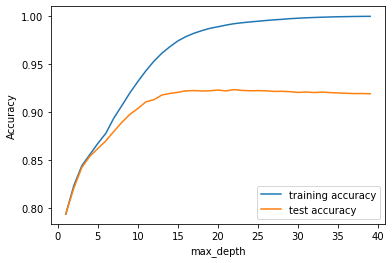

In [94]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# max_depth =10 seems to be the optimal one

In [95]:
# lets find optimal value of minimum sample leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [96]:
# grid search results
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.040636,0.149112,0.002807,0.000385,5,{'min_samples_leaf': 5},0.880940,0.922740,0.925793,0.920218,...,0.914114,0.016700,1,0.972023,0.966183,0.966449,0.966482,0.965586,0.967345,0.002361
1,1.007622,0.091782,0.003207,0.000399,25,{'min_samples_leaf': 25},0.861295,0.906146,0.903359,0.907076,...,0.896167,0.017507,2,0.925196,0.918461,0.921150,0.920486,0.918229,0.920704,0.002513
2,0.923263,0.073239,0.003407,0.000806,45,{'min_samples_leaf': 45},0.858508,0.888491,0.896323,0.891942,...,0.886530,0.014367,3,0.910328,0.907012,0.902731,0.904225,0.902433,0.905346,0.002972
3,0.788026,0.076664,0.003001,0.000631,65,{'min_samples_leaf': 65},0.853597,0.888358,0.889685,0.886632,...,0.882202,0.014442,4,0.900372,0.895828,0.894202,0.893505,0.892941,0.895370,0.002682
4,0.936525,0.085296,0.002800,0.000401,85,{'min_samples_leaf': 85},0.848819,0.881057,0.889154,0.885968,...,0.878193,0.014914,5,0.894564,0.890983,0.887731,0.886669,0.885574,0.889104,0.003275


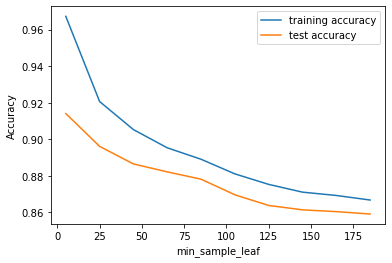

In [97]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# min_sample_leaf =25 seems to be the optimal one

In [98]:
# lets fine tune min sample split now
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [100]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

# min_samples_leaf=50 seems to be optimal

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.227618,0.160371,0.003409,0.000500,5,{'min_samples_split': 5},0.887576,0.928714,0.928315,0.925395,...,0.918628,0.015658,1,0.995121,0.993927,0.994192,0.994491,0.994226,0.994391,0.000406
1,1.226615,0.043093,0.003202,0.000401,25,{'min_samples_split': 25},0.876294,0.918890,0.919288,0.918094,...,0.909575,0.016698,2,0.968306,0.962135,0.962068,0.964955,0.963495,0.964192,0.002312
2,1.299729,0.152904,0.003206,0.000745,45,{'min_samples_split': 45},0.871516,0.915306,0.912253,0.909996,...,0.904504,0.016584,3,0.951016,0.946504,0.946537,0.948196,0.948528,0.948156,0.001653
3,1.606567,0.252079,0.004799,0.000979,65,{'min_samples_split': 65},0.865676,0.908669,0.908536,0.907872,...,0.899247,0.016825,4,0.940727,0.935353,0.934988,0.935917,0.933528,0.936103,0.002444
4,1.702145,0.384625,0.006406,0.003499,85,{'min_samples_split': 85},0.862490,0.904553,0.906279,0.903491,...,0.896725,0.017159,5,0.934621,0.928749,0.926360,0.927754,0.927090,0.928915,0.002960


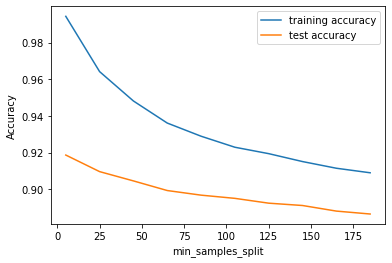

In [101]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# min_samples_leaf=50 seems to be optimal

In [102]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(25, 175, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [103]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)


Best Accuracy 0.8926095747686377


In [104]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=25, min_samples_split=50,
                       random_state=100)

In [105]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Accuracy Score for Decision Tree Final Model : 0.849976613657624


Conclusion from the Decision Tree Model:-
1. ~85% accuracy on the test dataset
2. A large number of false positives are present in the confusion matrix

### Random Forrest

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Prediction Making
prediction_test = model_rf.predict(X_test)
print ('Randon Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(y_test, prediction_test))

Randon Forest Accuracy with Default Hyperparameter 0.9413002806361085


In [107]:
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8075
           1       0.48      0.58      0.52       477

    accuracy                           0.94      8552
   macro avg       0.73      0.77      0.75      8552
weighted avg       0.95      0.94      0.94      8552



In [110]:
# GridSearchCV to find optimal n_estimators

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

In [111]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.087212,0.415113,0.076406,0.002423,2,{'max_depth': 2},0.813645,0.847206,0.847073,0.837780,...,0.840361,0.014560,4,0.840834,0.848870,0.836757,0.834169,0.843328,0.840791,0.005135
1,8.126337,1.310033,0.114342,0.018590,7,{'max_depth': 7},0.868994,0.892340,0.898580,0.895925,...,0.891016,0.011276,3,0.905516,0.899479,0.899048,0.898185,0.898583,0.900162,0.002712
2,13.779723,5.605764,0.210867,0.073263,12,{'max_depth': 12},0.923812,0.946635,0.947564,0.950219,...,0.943132,0.009735,2,0.971691,0.969004,0.967245,0.967577,0.967743,0.968652,0.001632
3,18.110329,0.924358,0.273353,0.041981,17,{'max_depth': 17},0.939209,0.960573,0.964689,0.967211,...,0.959327,0.010285,1,0.989878,0.989214,0.989015,0.988484,0.988816,0.989082,0.000465


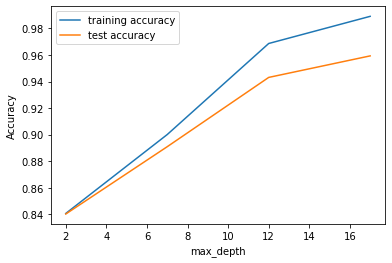

In [112]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
##Tuning n_estimators
## GridSearchCV to find optimal n_estimators
#from sklearn.model_selection import KFold
## specify number of folds for k-fold CV
n_folds = 5
#
## parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}
#
## instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=4)
#
#
## fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

In [ ]:

## scores of GridSearch CV
scores = rf.cv_results_
#
## plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 500, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
rf.fit(X_lasso, y_tr)



In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [ ]:
# fit the grid search with the data
grid_search.fit(X_lasso, y_tr)
# optimal accuracy score and hyperparameters
print('Accuracy is',grid_search.best_score_,'using',grid_search.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [ ]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

In [ ]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))

In [ ]:
# list of important features
X = df
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

#### Random Forest conclusions:
1. Avg. Reveue per Customer for Month 8 , Max Recharge Amount for Month 8 and local incoming for Month 8 are the most importantpredictor variables

### Overall Conclusion
1. Local Incoming and Outgoing Calls for 8th Month and avg revenue in 8th Month are the most important columns to predict churn.
2. Random Forest produced the best prediction results followed by SVM.
3. Max Recharge Amount is a strong feature to predict churn.
4. Cutomers with tenure less than 4 yrs are more likely to churn.
5. Revenue Per Customer are strong indicators of Churn and Std Outgoing Calls